### Load packages

In [1]:
import scanpy as sc
import episcanpy.api as epi
import numpy as np
import anndata as ad
import pandas as pd
import copy

/home/icb/anna.danese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/icb/anna.danese/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [3]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

# Pre-processing 10x

### Load the 10x windows count matrix

In [4]:
input_dir_10x = ''
adata = ad.read(input_dir_10x+'atac_v1_adult_brain_fresh_5k_fragments_AllCells.h5ad')
adata

AnnData object with n_obs × n_vars = 335609 × 545114 

### Filter barcodes

In [5]:
# Download and load the barcode file from 10x 
#!wget https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_adult_brain_fresh_5k/atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.tar.gz
#!gunzip -d atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.tar
#!tar -xvf atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.tar

In [7]:
with open('./filtered_peak_bc_matrix/barcodes.tsv') as f:
    barcodes = f.readlines()
    barcodes = [x.rstrip('\n') for x in barcodes]
    
annot = []
for name in adata.obs_names.tolist():
    if name in barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter_barcode_cellranger'] = annot
del barcodes

adata = adata[adata.obs['filter_barcode_cellranger']=='keep',:].copy()
adata

AnnData object with n_obs × n_vars = 3880 × 545114 
    obs: 'filter_barcode_cellranger'

In [8]:
# binarize the matrix
print(np.max(adata.X))
epi.pp.binarize(adata)
print(np.max(adata.X))

298.0
1.0


### Preliminary filtering

In [9]:
epi.pp.filter_cells(adata, min_features=100)
adata

AnnData object with n_obs × n_vars = 3879 × 545114 
    obs: 'filter_barcode_cellranger', 'nb_features'

In [10]:
epi.pp.filter_features(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3879 × 459980 
    obs: 'filter_barcode_cellranger', 'nb_features'
    var: 'n_cells'

### Quality controls & filtering

In [11]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 3879 × 459980 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'filter_barcode_cellranger' as categorical


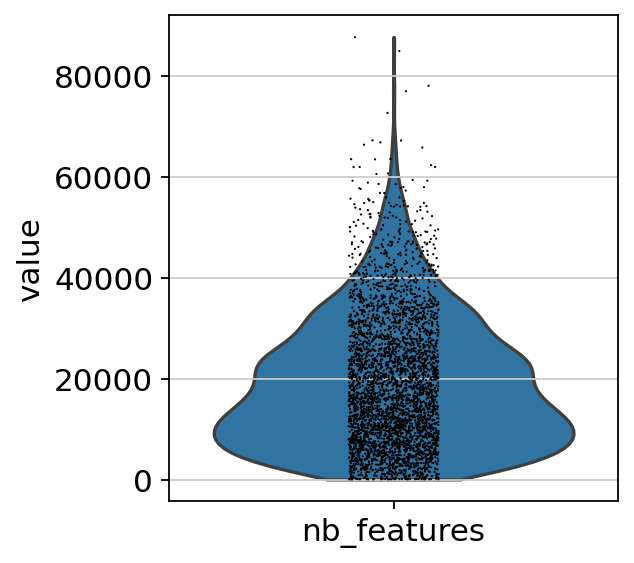

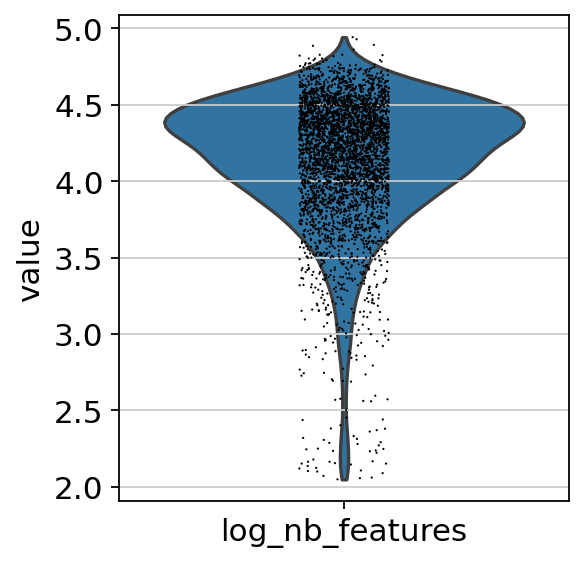

In [12]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

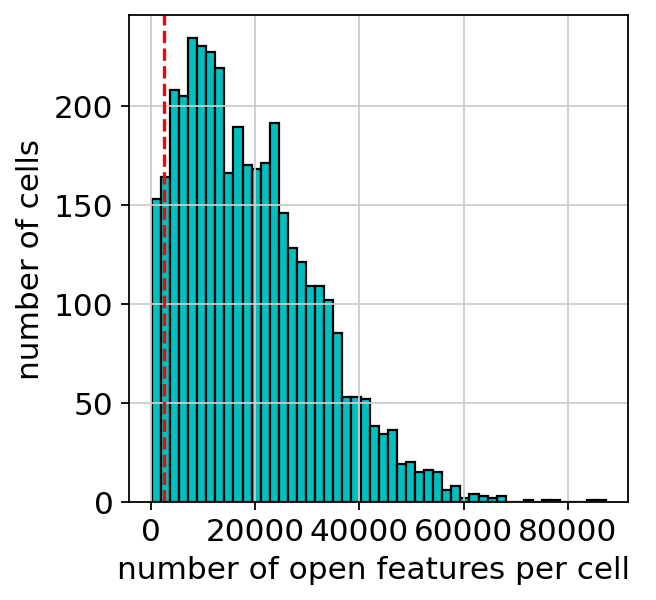

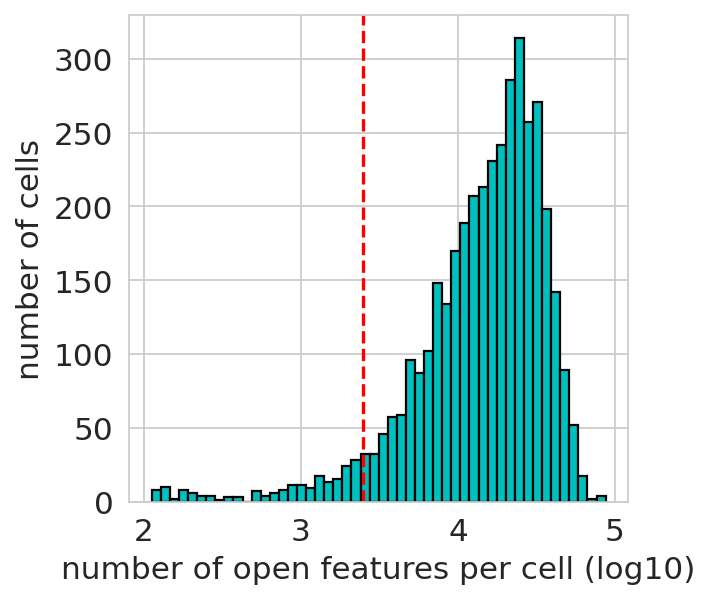

In [13]:
# set a minimum number of cells to keep 
min_features = 2500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_windows_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_windows_coverage_cells_log10.png')

In [14]:
# filter the cells not passing QC
min_features = 2500
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 3667 × 459980 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

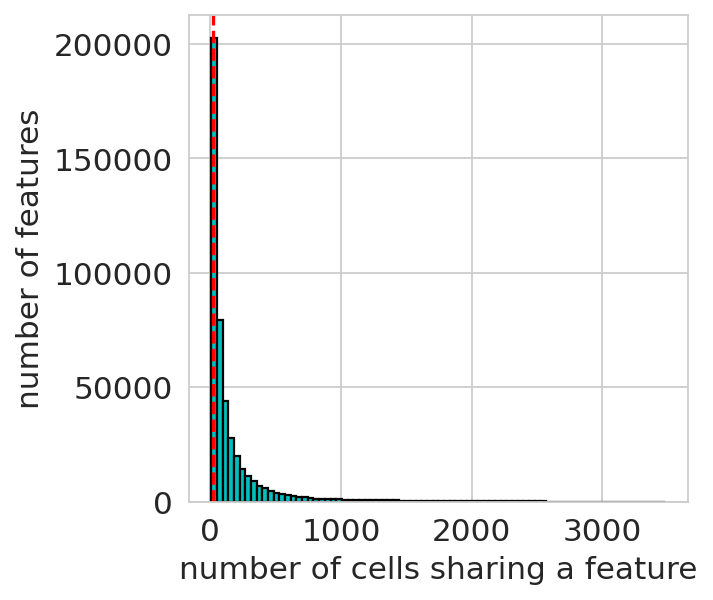

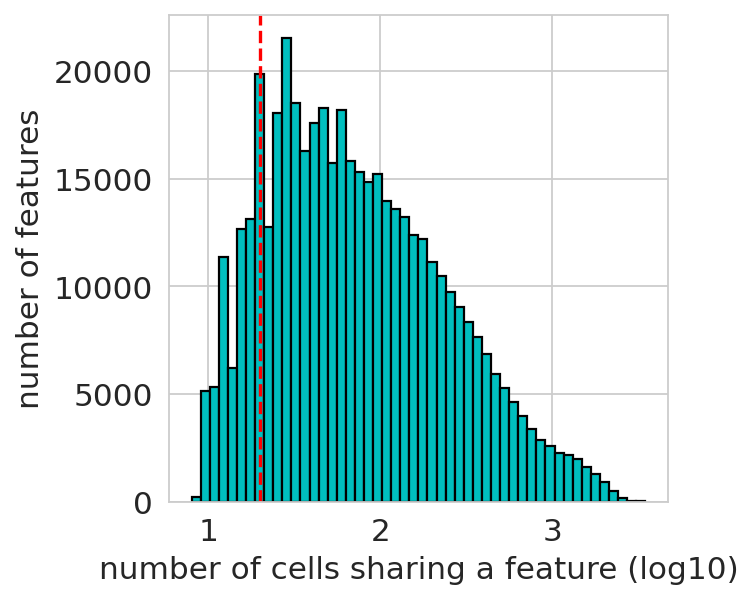

In [15]:
# minimum number of cells sharing a feature
min_cells = 20
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_windows_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_windows_coverage_log10.png')

In [16]:
# filter the features not passing QC
min_cells = 20
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 3667 × 399401 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

### QC post filtering

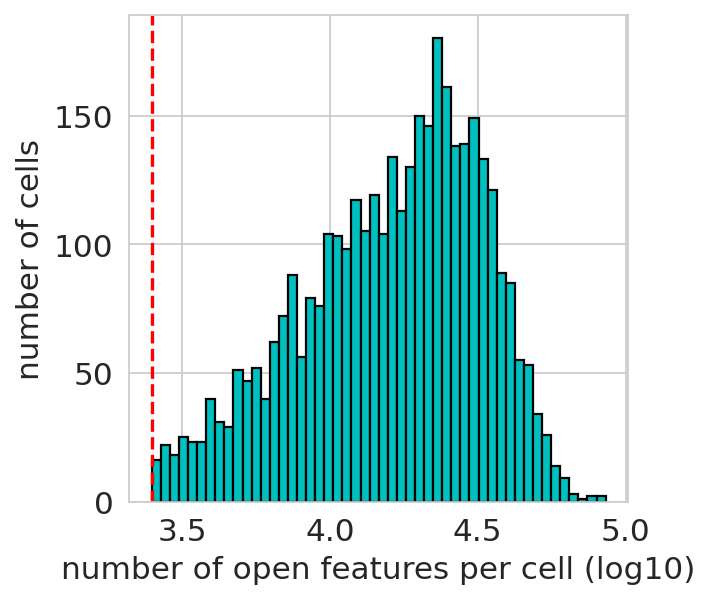

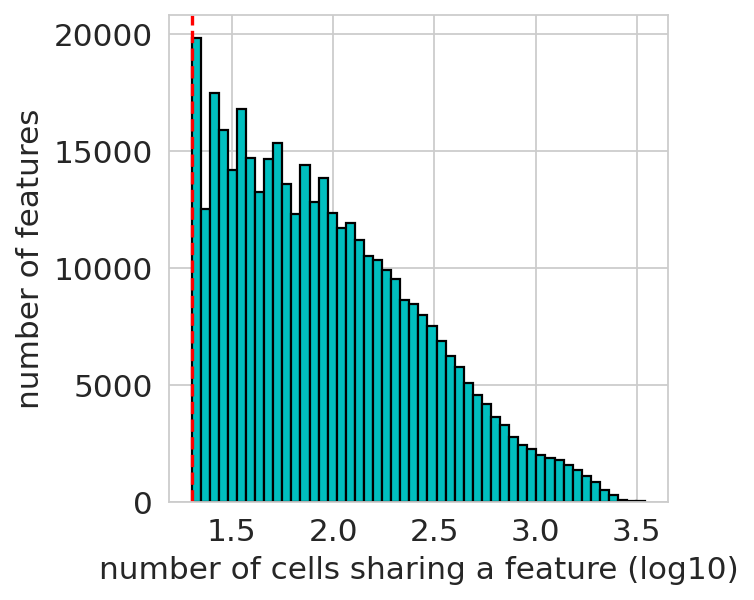

In [17]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

### Feature selection

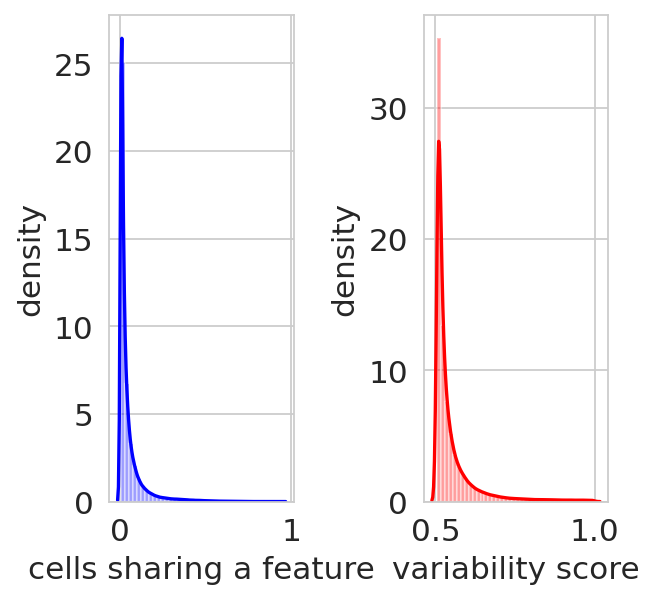

In [18]:
epi.pp.cal_var(adata)

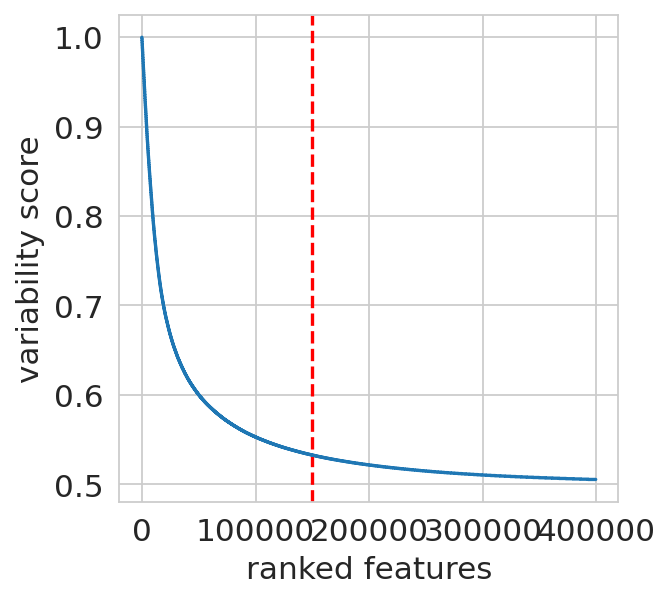

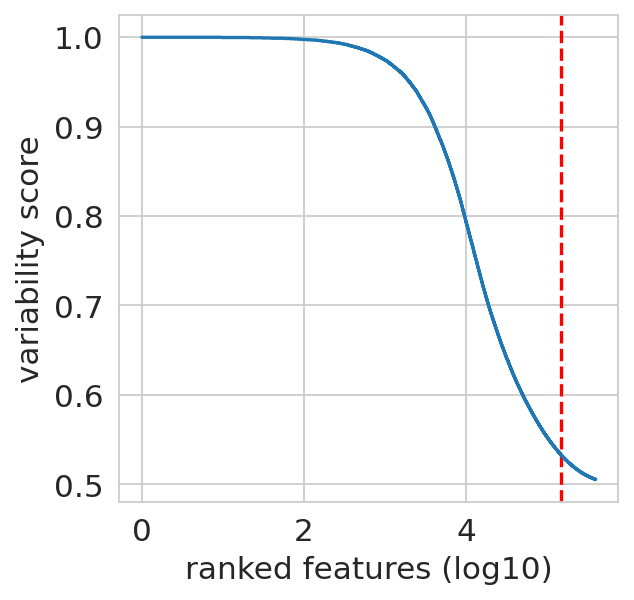

In [19]:
nb_feature_selected = 150000
epi.pl.variability_features(adata,log=None, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_windows.png')

epi.pl.variability_features(adata,log='log10', nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_windows_log10.png')

In [20]:
# save the current matrix in the raw layer
adata.raw = adata

In [21]:
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [22]:
adata

View of AnnData object with n_obs × n_vars = 3667 × 150351 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

### Embedding and visualisation

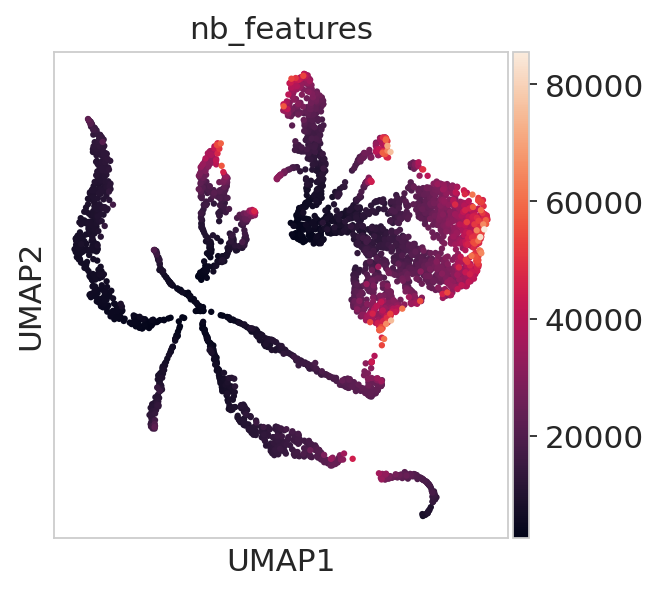

In [23]:
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features'], wspace=0.3)

In [24]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata.layers['counts'] = adata.X.copy()

## Pre-processing large Fang

Load and merge all the Fang samples

In [25]:
input_dir_Fang = ''

adata2 = ad.read(input_dir_Fang+'CEMBA180305_2B_AllCells.h5ad')
adata2

AnnData object with n_obs × n_vars = 88281 × 545118 

In [26]:
adata3 = ad.read(input_dir_Fang+'CEMBA180306_2B_AllCells.h5ad')
adata3

AnnData object with n_obs × n_vars = 89079 × 545118 

In [27]:
adata2 = adata2.concatenate(adata3)

batchname=copy.copy(adata2.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'CEMBA180306_2B', '0' : 'CEMBA180305_2B' })
batchname

adata2.obs['batchname_Fang'] = batchname
adata2

AnnData object with n_obs × n_vars = 177360 × 545118 
    obs: 'batch', 'batchname_Fang'

In [28]:
adata3 = ad.read(input_dir_Fang+'CEMBA180226_1A_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180226_1A', regex=False)
adata2

AnnData object with n_obs × n_vars = 263973 × 545118 
    obs: 'batch', 'batchname_Fang'

In [29]:
adata3 = ad.read(input_dir_Fang+'CEMBA180227_1A_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180227_1A', regex=False)
adata2

AnnData object with n_obs × n_vars = 342733 × 545118 
    obs: 'batch', 'batchname_Fang'

In [30]:
adata3 = ad.read(input_dir_Fang+'CEMBA180308_3B_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180308_3B', regex=False)
adata2

AnnData object with n_obs × n_vars = 435877 × 545118 
    obs: 'batch', 'batchname_Fang'

In [31]:
adata3 = ad.read(input_dir_Fang+'CEMBA180312_3B_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180312_3B', regex=False)
adata2

AnnData object with n_obs × n_vars = 523418 × 545118 
    obs: 'batch', 'batchname_Fang'

In [32]:
del adata3

In [33]:
# binarize the matrix
print(np.max(adata2.X))
epi.pp.binarize(adata2)
print(np.max(adata2.X))

16836.0
1.0


### Preliminary filtering

In [34]:
epi.pp.filter_cells(adata2, min_features=100)
adata2

AnnData object with n_obs × n_vars = 86115 × 545118 
    obs: 'batch', 'batchname_Fang', 'nb_features'

In [35]:
epi.pp.filter_features(adata2, min_cells=10)
adata2

AnnData object with n_obs × n_vars = 86115 × 497251 
    obs: 'batch', 'batchname_Fang', 'nb_features'
    var: 'n_cells'

### Quality controls & filtering

In [36]:
adata2.obs['log_nb_features'] = [np.log10(x) for x in adata2.obs['nb_features']]
adata2

AnnData object with n_obs × n_vars = 86115 × 497251 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'batchname_Fang' as categorical


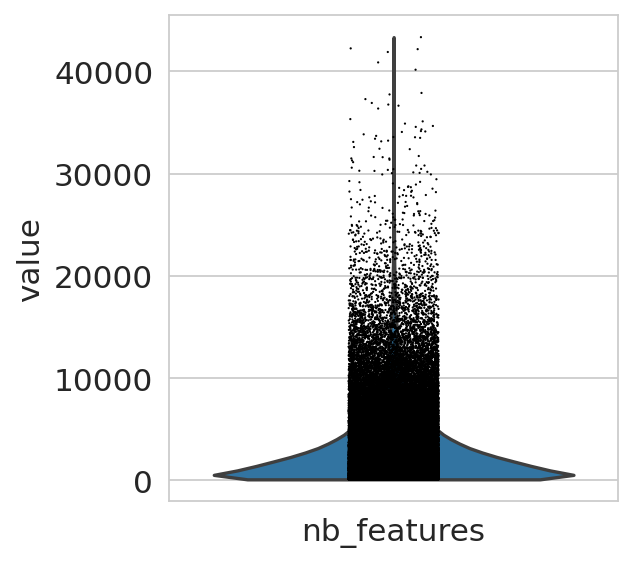

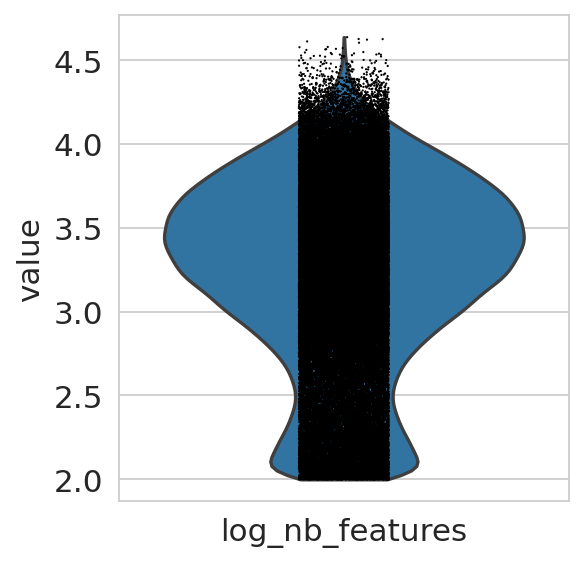

In [37]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

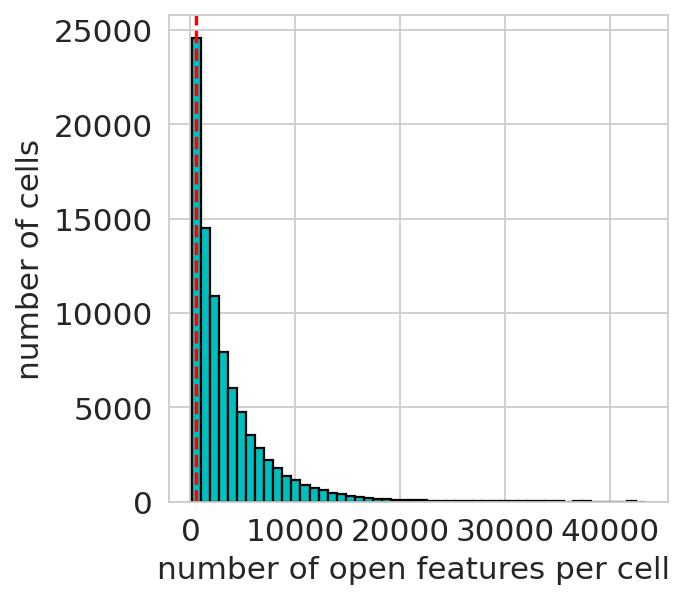

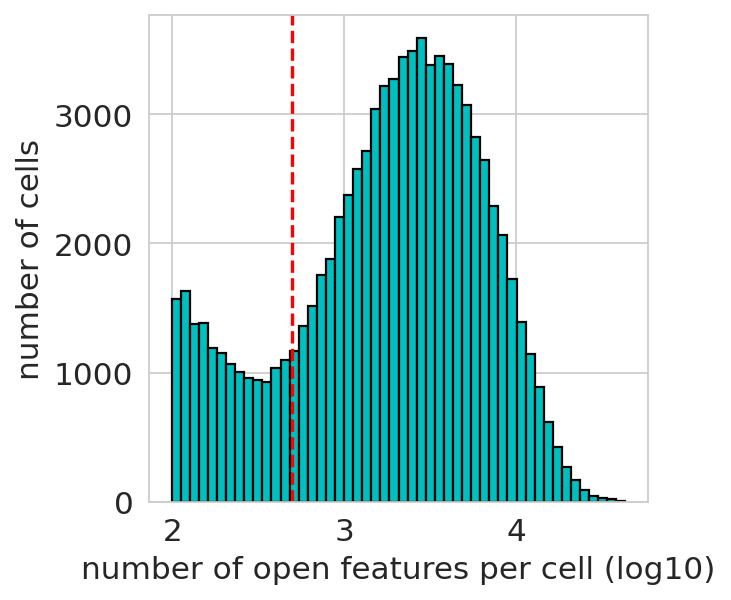

In [38]:
# set a minimum number of cells to keep 
min_features = 500

epi.pp.coverage_cells(adata2, binary=True, log=False, bins=50,
               threshold=min_features, save='Fang_large_windows_coverage_cells.png')
epi.pp.coverage_cells(adata2, binary=True, log=10, bins=50,
               threshold=min_features, save='Fang_large_windows_coverage_cells_log10.png')

In [39]:
# filter the cells not passing QC
min_features = 500
epi.pp.filter_cells(adata2, min_features=min_features)
adata2

AnnData object with n_obs × n_vars = 70435 × 497251 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells'

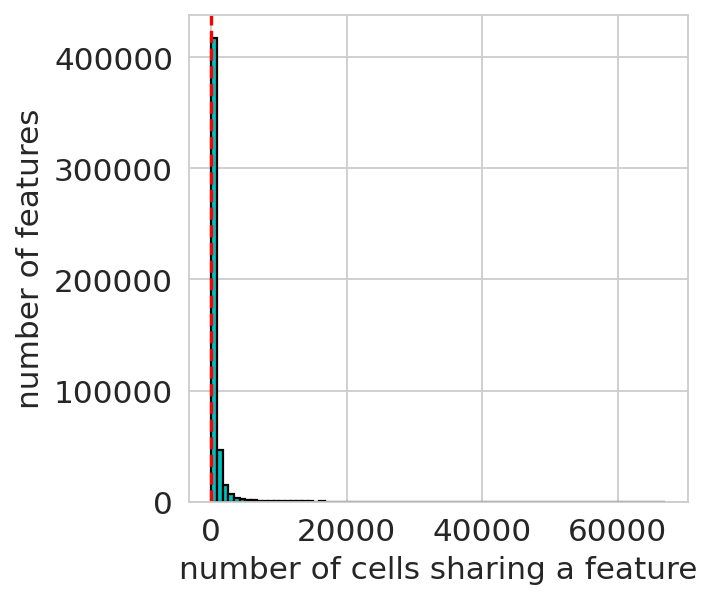

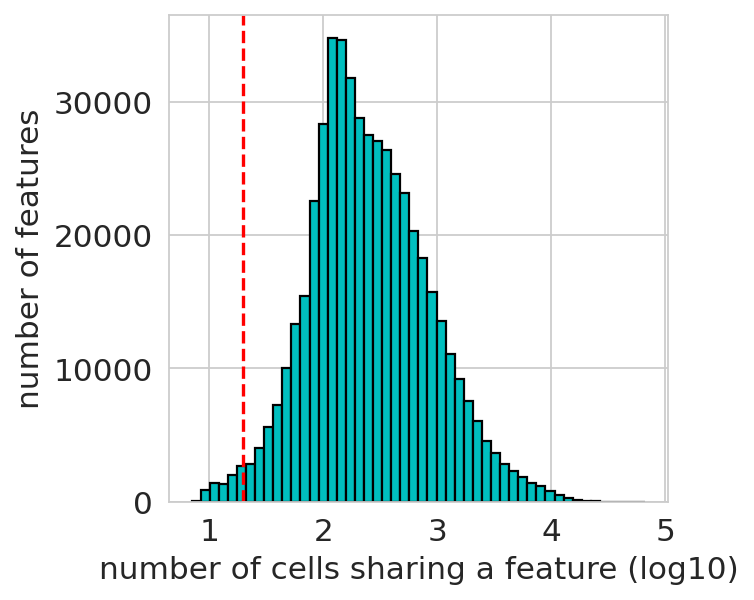

In [40]:
# minimum number of cells sharing a feature
min_cells = 20
epi.pp.coverage_features(adata2, binary=True, log=False, 
                        threshold=min_cells, save='Fang_large_windows_coverage.png')
epi.pp.coverage_features(adata2, binary=True, log=True, 
                        threshold=min_cells, save='Fang_large_windows_coverage_log10.png')

In [41]:
# filter the features not passing QC
min_cells = 20
epi.pp.filter_features(adata2, min_cells=min_cells)
adata2

AnnData object with n_obs × n_vars = 70435 × 490282 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

### QC post filtering

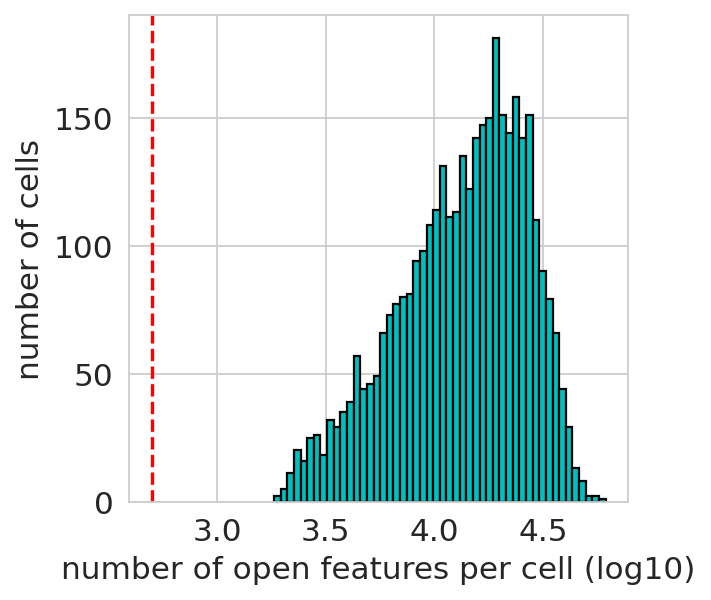

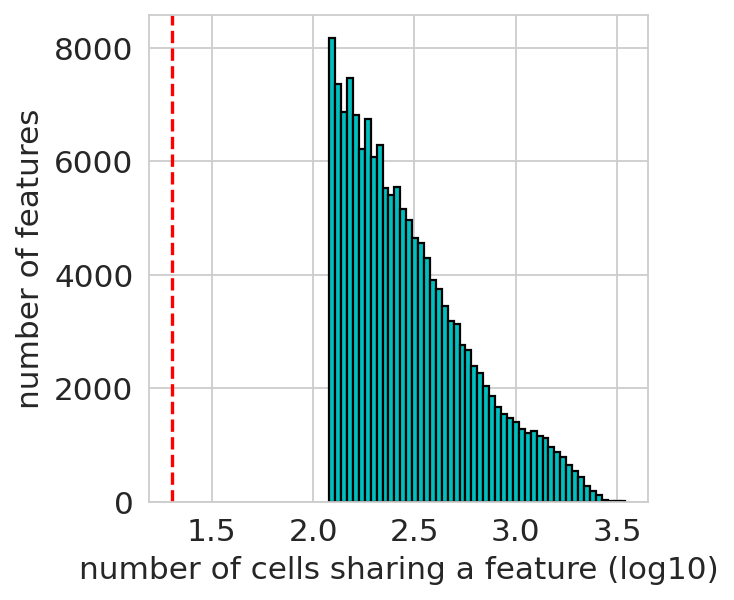

In [42]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

### Feature selection

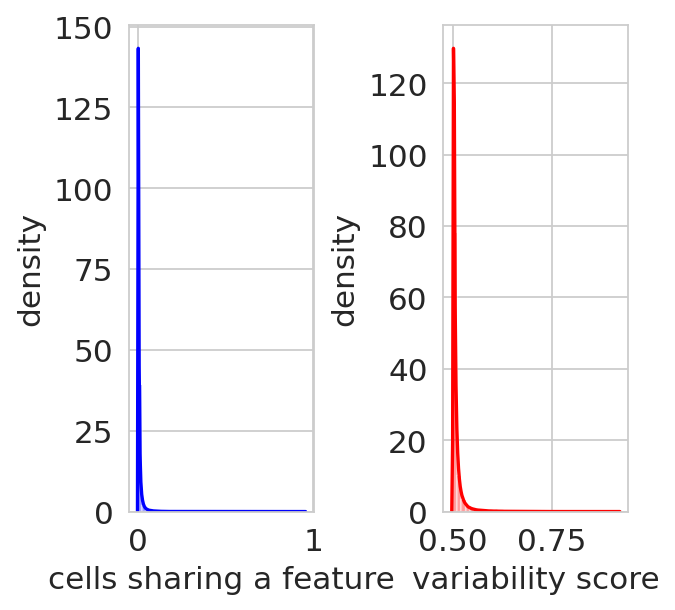

In [43]:
epi.pp.cal_var(adata2)

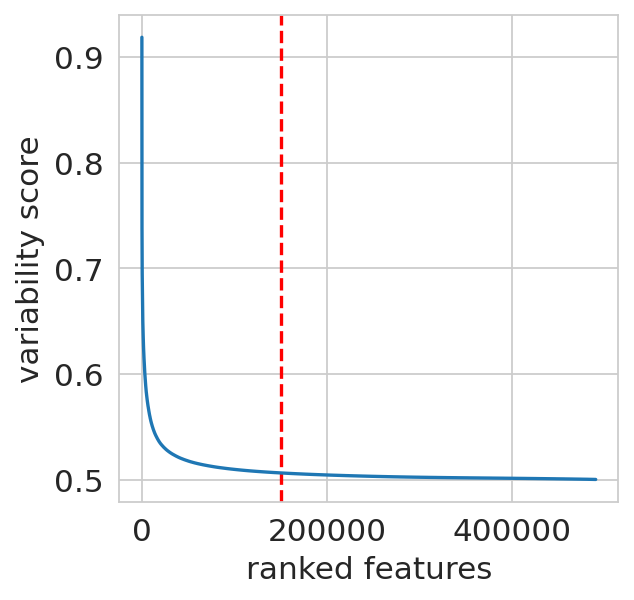

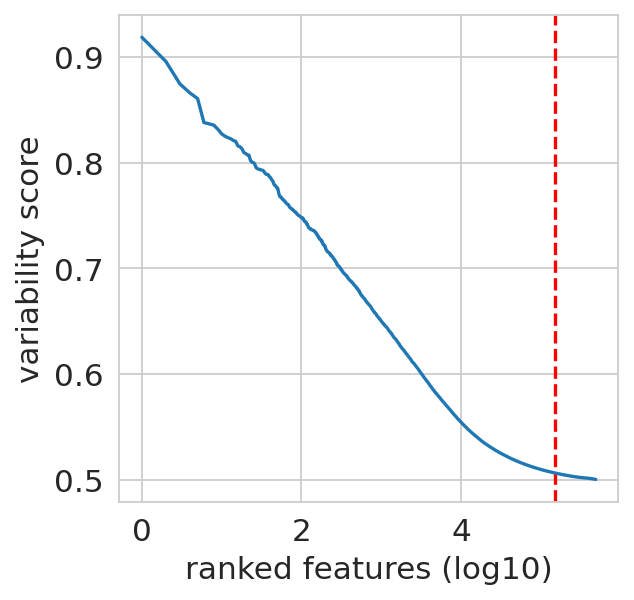

In [44]:
nb_feature_selected = 150000
epi.pl.variability_features(adata2,log=None, nb_features=nb_feature_selected,
                     save='variability_features_plot_large_windows.png')

epi.pl.variability_features(adata2,log='log10', nb_features=nb_feature_selected,
                     save='variability_features_plot_large_windows_log10.png')

In [45]:
adata2

AnnData object with n_obs × n_vars = 70435 × 490282 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [46]:
# save the current matrix in the raw layer
adata2.raw = adata2

In [47]:
# create a new AnnData containing only the most variable features
adata2 = epi.pp.select_var_feature(adata2,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [48]:
adata2

View of AnnData object with n_obs × n_vars = 70435 × 150141 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

### Embedding and visualisation

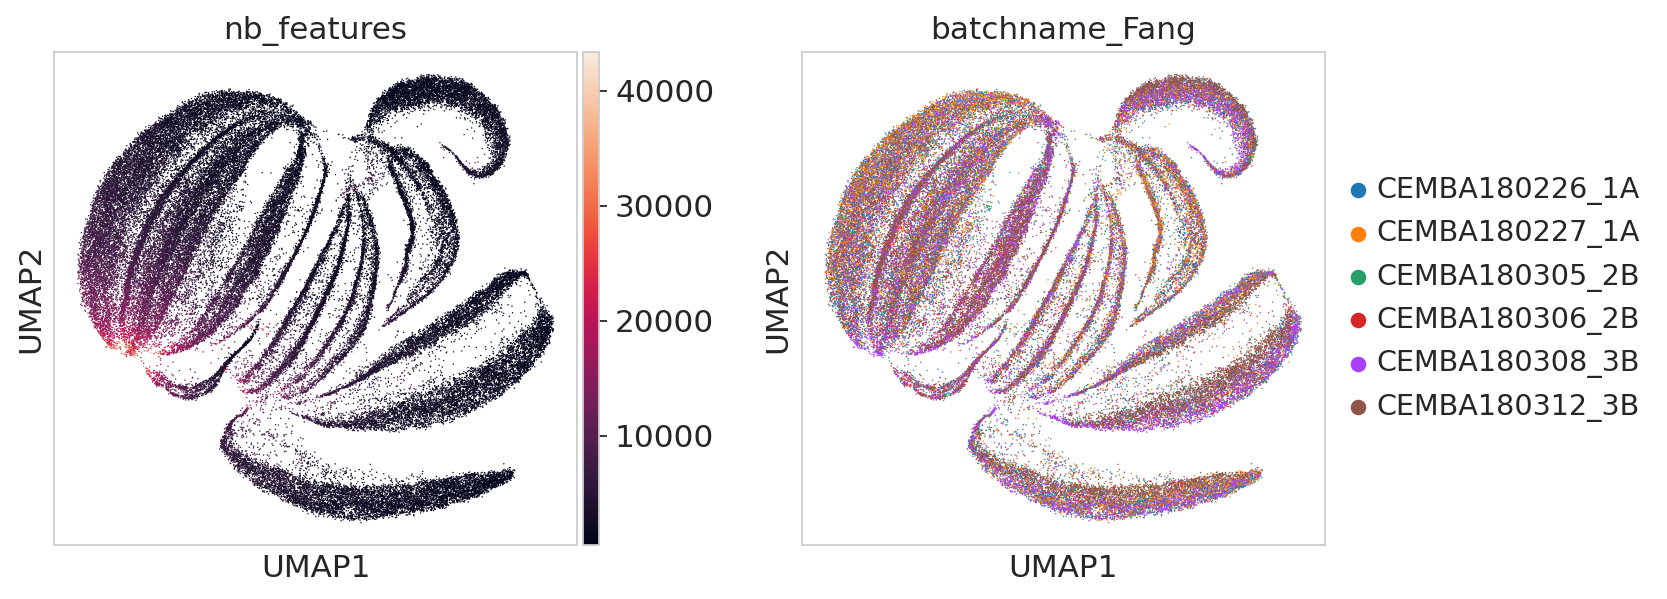

In [49]:
epi.pp.lazy(adata2)
sc.pl.umap(adata2, color=['nb_features', 'batchname_Fang'], wspace=0.3)

In [50]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata2.layers['counts'] = adata2.X.copy()

## Pre-processing Cusanovich large
Load and merge all the Cusanovich samples

In [51]:
input_dir_Cusanovich = ''

In [52]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819246_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819247_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adata3 = adatacus1.copy()
adata3.X = adata3.X+adatacus2.X


del adata3.obs['filter'], adatacus1, adatacus2

adata3

AnnData object with n_obs × n_vars = 35035 × 545118 

In [53]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819248_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819249_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2




adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'WholeBrainA_62816', '0' : 'WholeBrainA_62216' })
batchname

adata3.obs['batchname_Cusanovich'] = batchname
adata3.obs['batchname'] = batchname
adata3

AnnData object with n_obs × n_vars = 52541 × 545118 
    obs: 'batch', 'batchname_Cusanovich', 'batchname'

In [54]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819238_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819239_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2


adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

adata3.obs['batchname_Cusanovich'] = adata3.obs['batchname_Cusanovich'].replace(np.nan, 'PreFrontalCortex_62216', regex=False)
adata3.obs['batchname'] = adata3.obs['batchname'].replace(np.nan, 'PreFrontalCortex_62216', regex=False)

adata3

AnnData object with n_obs × n_vars = 85403 × 545118 
    obs: 'batch', 'batchname', 'batchname_Cusanovich'

In [55]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819220_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819221_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2


adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

adata3.obs['batchname_Cusanovich'] = adata3.obs['batchname_Cusanovich'].replace(np.nan, 'Cerebellum_62216', regex=False)
adata3.obs['batchname'] = adata3.obs['batchname'].replace(np.nan, 'Cerebellum_62216', regex=False)


adata3

AnnData object with n_obs × n_vars = 103454 × 545118 
    obs: 'batch', 'batchname', 'batchname_Cusanovich'

In [56]:
set(adata3.obs['batchname_Cusanovich'])

{'Cerebellum_62216',
 'PreFrontalCortex_62216',
 'WholeBrainA_62216',
 'WholeBrainA_62816'}

In [57]:
del adatatmp

In [58]:
# check if the data matrix is binary 
print(np.max(adata3.X))
epi.pp.binarize(adata3)
print(np.max(adata3.X))

3577.0
1.0


### Preliminary filtering

In [59]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata3, min_features=1)
adata3

AnnData object with n_obs × n_vars = 103454 × 545118 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features'

In [60]:
epi.pp.filter_features(adata3, min_cells=1)
adata3

AnnData object with n_obs × n_vars = 103454 × 512951 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features'
    var: 'n_cells'

### Quality controls & filtering

In [61]:
adata3.obs['log_nb_features'] = [np.log10(x) for x in adata3.obs['nb_features']]
adata3

AnnData object with n_obs × n_vars = 103454 × 512951 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features', 'log_nb_features'
    var: 'n_cells'

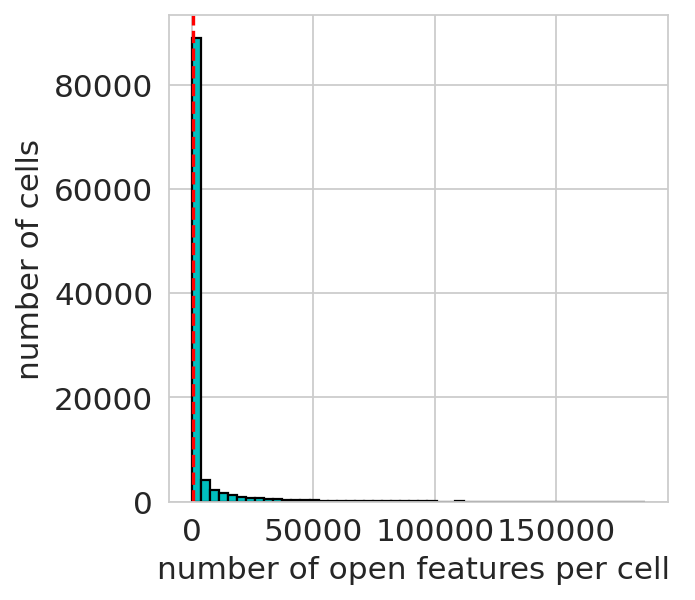

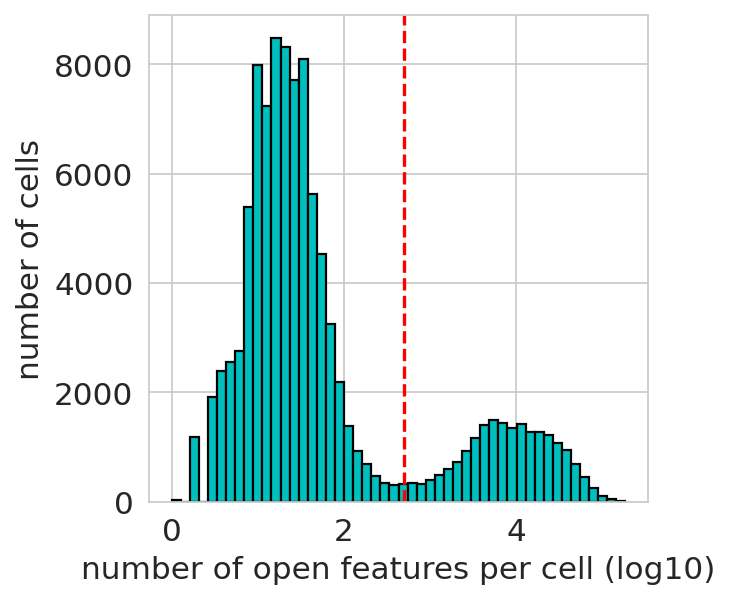

In [62]:
# set a minimum number of cells to keep 
min_features = 500

epi.pp.coverage_cells(adata3, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_windows_large.png')
epi.pp.coverage_cells(adata3, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_windows_large_log10.png')

In [63]:
min_features = 500
epi.pp.filter_cells(adata3, min_features=min_features)

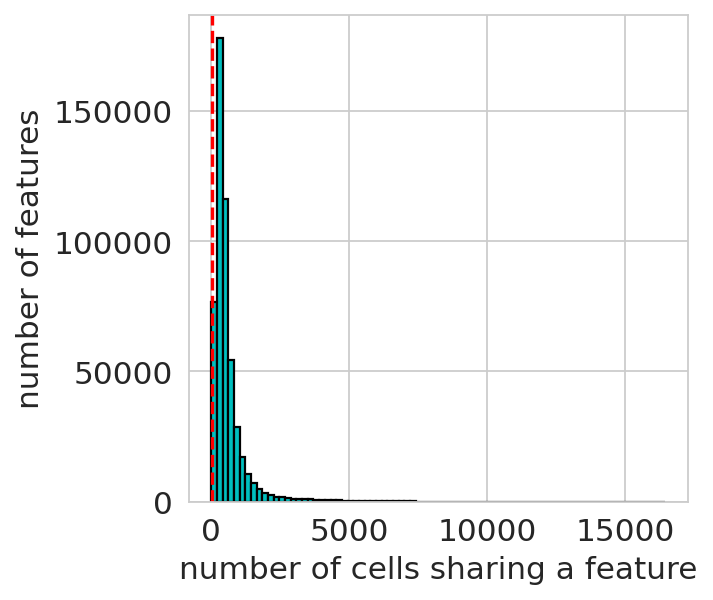

In [64]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata3, binary=True, log=False, 
                        threshold=min_cells, save='Cusanovich_large_windows_coverage.png')
#epi.pp.coverage_features(adata3, binary=True, log=True, 
#                        threshold=min_cells, save='Cusanovich_large_windows_coverage_log10.png')

In [65]:
min_cells = 10
epi.pp.filter_features(adata3, min_cells=min_cells)

In [66]:
adata3

AnnData object with n_obs × n_vars = 19497 × 502470 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

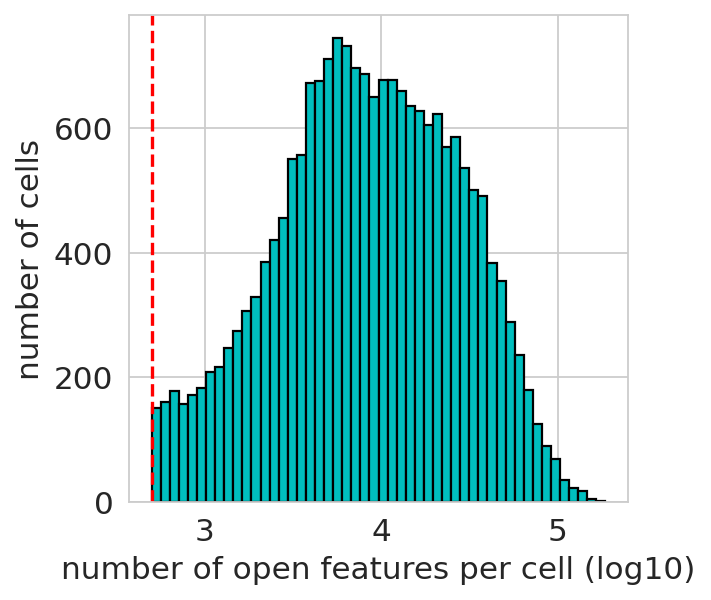

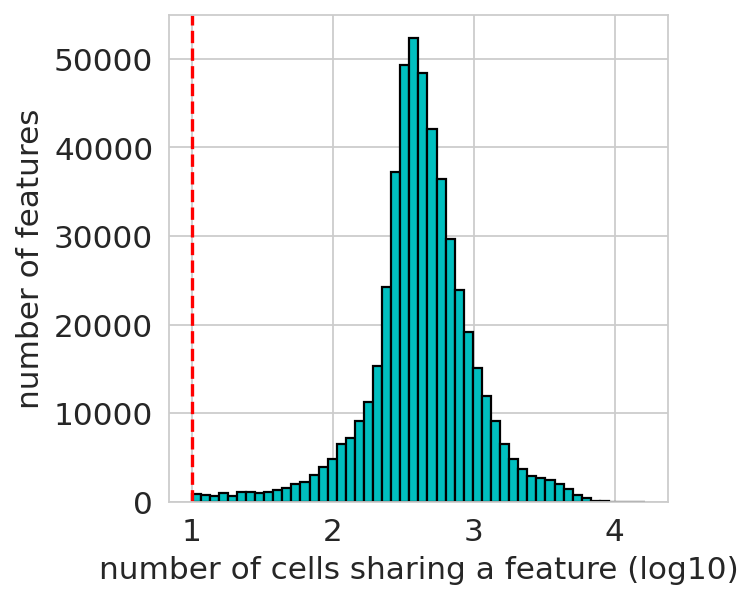

In [67]:
epi.pp.coverage_cells(adata3, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata3, binary=True, log='log10', bins=50, threshold=min_cells)

### Feature selection

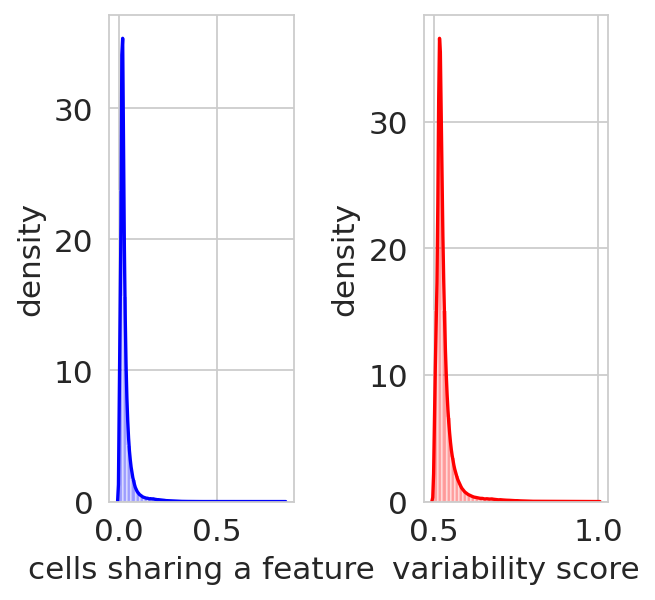

In [68]:
epi.pp.cal_var(adata3)

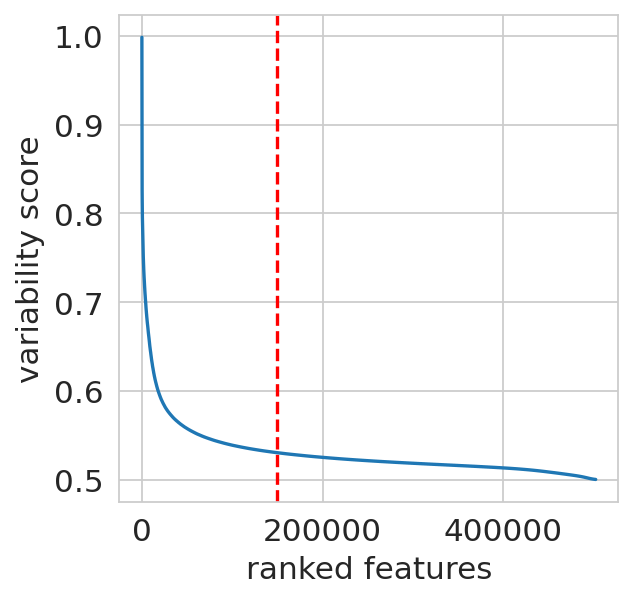

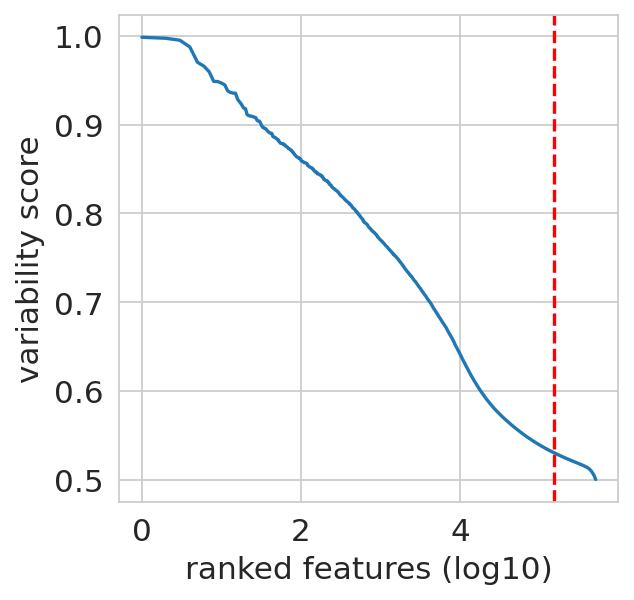

In [69]:
nb_feature_selected = 150000
epi.pl.variability_features(adata3,log=None, nb_features=nb_feature_selected,
                           save='variability_features_plot_Cusanovich_large_windows.png')

epi.pl.variability_features(adata3,log='log10', nb_features=nb_feature_selected,
                     save='variability_features_plot_Cusanovich_large_windows_log10.png')

In [70]:
# save the current matrix in the raw layer
adata3.raw = adata3

In [71]:
# create a new AnnData containing only the most variable features
adata3 = epi.pp.select_var_feature(adata3,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [72]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()

In [73]:
adata3

AnnData object with n_obs × n_vars = 19497 × 150102 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'counts'

### Embedding and visualisation

... storing 'batchname' as categorical
... storing 'batchname_Cusanovich' as categorical


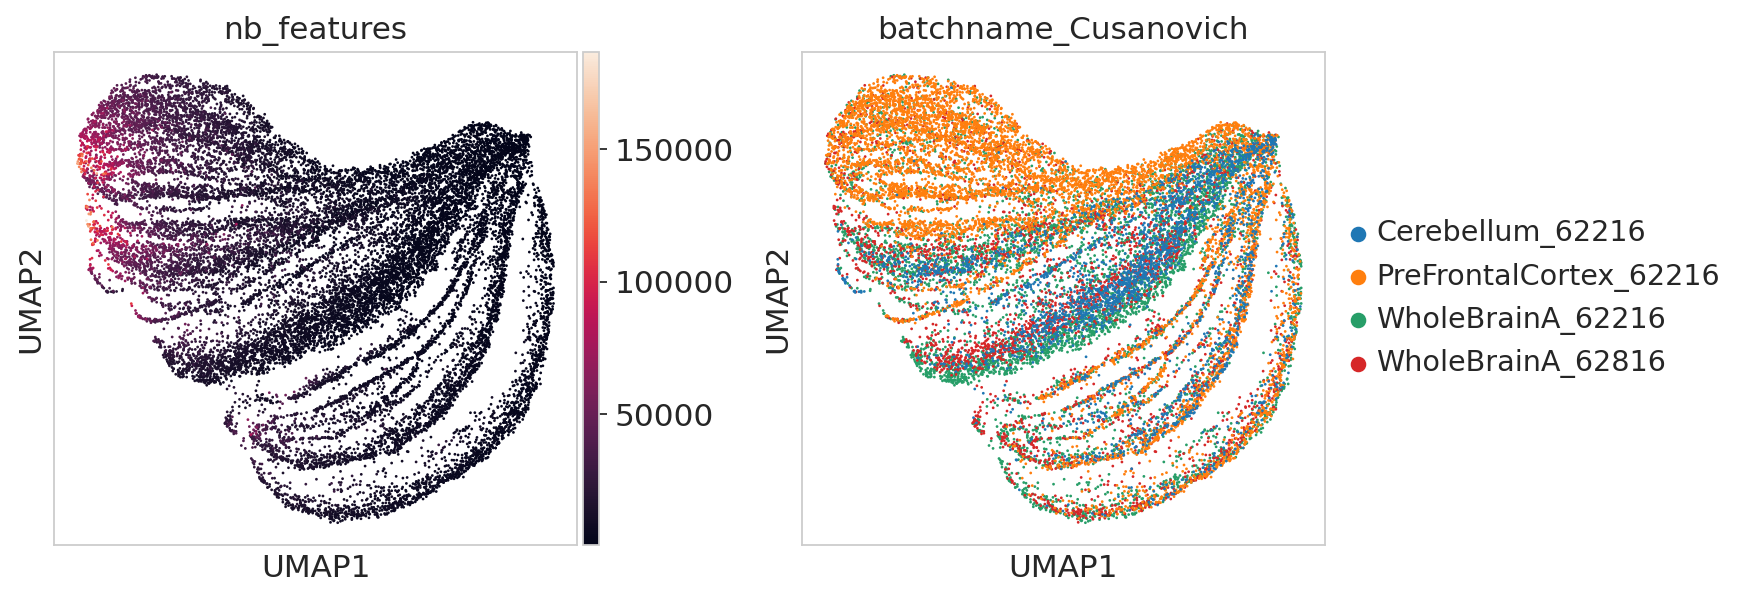

In [74]:
epi.pp.lazy(adata3)
sc.pl.umap(adata3, color=['nb_features', 'batchname_Cusanovich'], wspace=0.3)

In [75]:
adata3

AnnData object with n_obs × n_vars = 19497 × 150102 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'umap', 'batchname_Cusanovich_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Merging datasets

In [76]:
# merging 10x and Fang
adatamerged = adata.concatenate(adata2)
adatamerged

AnnData object with n_obs × n_vars = 74102 × 128764 
    obs: 'batch', 'batchname_Fang', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

In [77]:
batchname=copy.copy(adatamerged.obs['batch'])
batchname = batchname.map({ '1' : 'Fang et al.', '0' : '10x Genomics' })
adatamerged.obs['batchname'] = batchname
adatamerged

AnnData object with n_obs × n_vars = 74102 × 128764 
    obs: 'batch', 'batchname_Fang', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

### Temporary embedding

In [78]:
epi.pp.lazy(adatamerged)

... storing 'batchname_Fang' as categorical
... storing 'filter_barcode_cellranger' as categorical


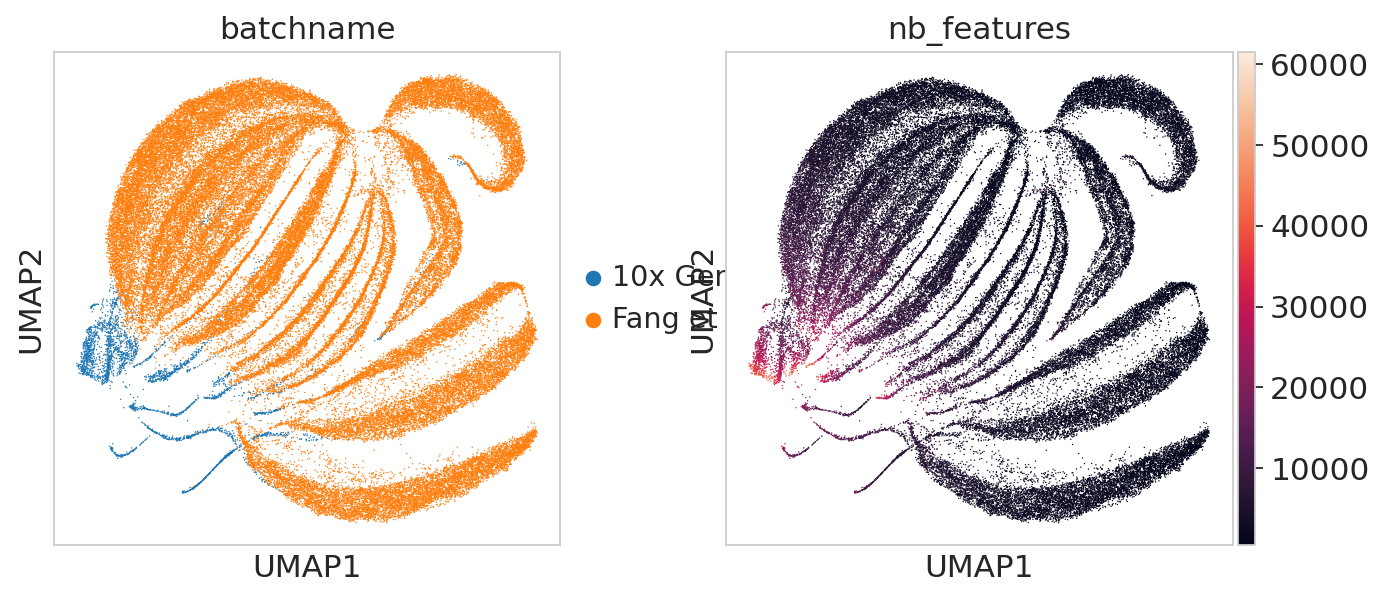

In [79]:
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'])

In [80]:
# adding Cusanovich data
adatamerged = adatamerged.concatenate(adata3)
adatamerged

AnnData object with n_obs × n_vars = 93599 × 118723 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

In [81]:
adatamerged.obs['batchname'] = adatamerged.obs['batchname'].replace(np.nan, 'Cusanovich et al.', regex=False)

annot = []
index = 0
for n in adatamerged.obs_names.tolist():
    if adatamerged.obs['batchname'][index] == '10x Genomics':
        annot.append('10x Genomics')
    elif adatamerged.obs['batchname'][index] == 'Cusanovich et al.':
        annot.append(' - '.join(['Fang et al.', adatamerged.obs['batchname_Cusanovich'][index]]))
    elif adatamerged.obs['batchname'][index] == 'Fang et al.':
        annot.append(' - '.join(['Fang et al.', adatamerged.obs['batchname_Fang'][index]]))
    else:
        annot.append(n)
    index += 1
    
adatamerged.obs['batchname_all'] = annot

In [82]:
contingency_table_prefilt = pd.crosstab(adatamerged.obs['batchname'],
                                adatamerged.obs['batchname'],
                                margins = True)
print(contingency_table_prefilt)

batchname               10x Genomics  Cerebellum_62216  Fang et al.  \
batchname                                                             
10x Genomics                    3667                 0            0   
Cerebellum_62216                   0              2749            0   
Fang et al.                        0                 0        70435   
PreFrontalCortex_62216             0                 0            0   
WholeBrainA_62216                  0                 0            0   
WholeBrainA_62816                  0                 0            0   
All                             3667              2749        70435   

batchname               PreFrontalCortex_62216  WholeBrainA_62216  \
batchname                                                           
10x Genomics                                 0                  0   
Cerebellum_62216                             0                  0   
Fang et al.                                  0                  0   
PreFrontalCorte

In [83]:
contingency_table_prefilt = pd.crosstab(adatamerged.obs['batchname_all'],
                                adatamerged.obs['batchname_all'],
                                margins = True)
print(contingency_table_prefilt)

batchname_all                                 10x Genomics  \
batchname_all                                                
10x Genomics                                          3667   
AGCGATAGAACGAATTCGACCTACGCCAGGCTCTGA-1-0-1               0   
AGCGATAGAACGAATTCGACTCGTATCAAGGCGAAG-1-0-1               0   
AGCGATAGAACGAATTCGACTCGTATCACAGGACGT-1-0-1               0   
AGCGATAGAACGAATTCGAGGCGAGAGCGGCTCTGA-0-0-0-1             0   
...                                                    ...   
TCTCGCGCTTGCTTAGATTCCTTATAGACCTATCCT-1-0-1               0   
TCTCGCGCTTGGCAAGCCTTATGACCAAGGCTCTGA-1-1                 0   
TCTCGCGCTTGGTAAGGATCAATATCGAGGCTCTGA-1-1                 0   
TCTCGCGCTTGGTAAGGATTATGACCAATATAGCCT-1-1                 0   
All                                                   3667   

batchname_all                                 AGCGATAGAACGAATTCGACCTACGCCAGGCTCTGA-1-0-1  \
batchname_all                                                                              
10x Genom

### Filtering cells that do not contain sufficient data

In [84]:
epi.pp.filter_cells(adatamerged, min_features=500)

In [85]:
contingency_table_prefilt = pd.crosstab(adatamerged.obs['batchname'],
                                adatamerged.obs['batchname'],
                                margins = True)
print(contingency_table_prefilt)

batchname               10x Genomics  Cerebellum_62216  Fang et al.  \
batchname                                                             
10x Genomics                    3667                 0            0   
Cerebellum_62216                   0              2531            0   
Fang et al.                        0                 0        65734   
PreFrontalCortex_62216             0                 0            0   
WholeBrainA_62216                  0                 0            0   
WholeBrainA_62816                  0                 0            0   
All                             3667              2531        65734   

batchname               PreFrontalCortex_62216  WholeBrainA_62216  \
batchname                                                           
10x Genomics                                 0                  0   
Cerebellum_62216                             0                  0   
Fang et al.                                  0                  0   
PreFrontalCorte

In [86]:
adatamerged.layers['counts'] = adatamerged.X

### Embedding and Visualisation

In [87]:
epi.pp.lazy(adatamerged)

... storing 'batchname' as categorical
... storing 'batchname_Cusanovich' as categorical
... storing 'batchname_Fang' as categorical
... storing 'filter_barcode_cellranger' as categorical
... storing 'batchname_all' as categorical


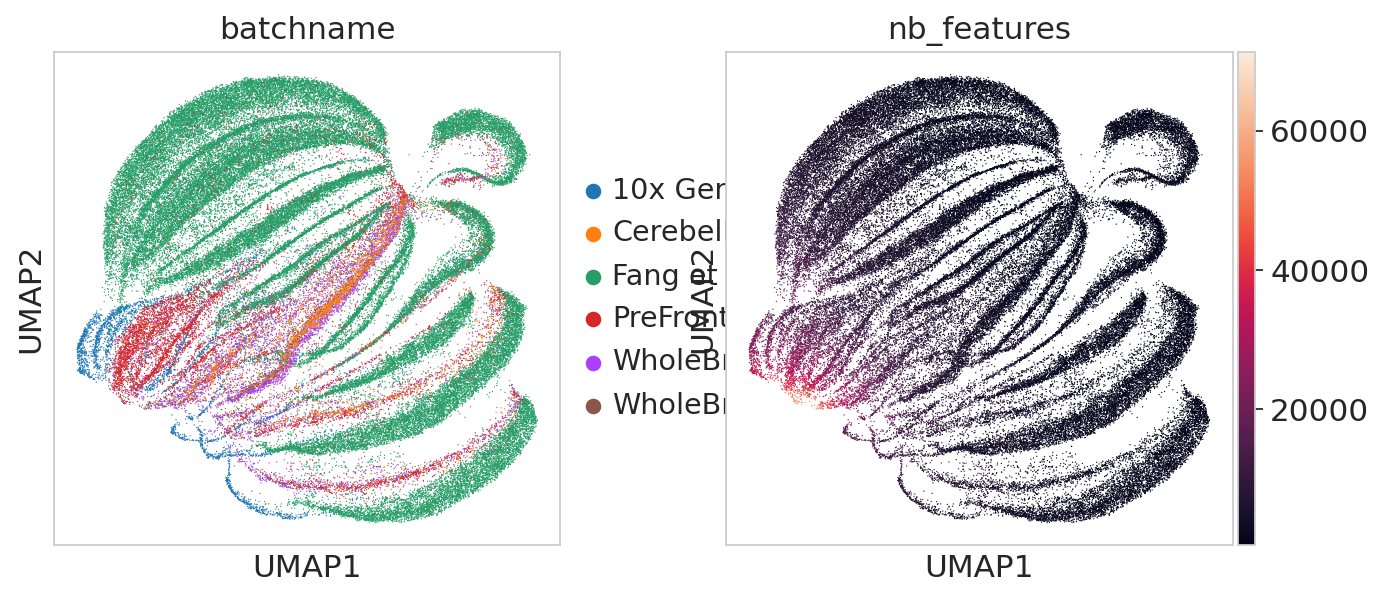

In [88]:
epi.pl.umap(adatamerged, color=['batchname', 'nb_features'])

### Normalisation

In [89]:
epi.pp.normalize_per_cell(adatamerged)

### Embedding and visualisation

In [90]:
epi.pp.lazy(adatamerged)

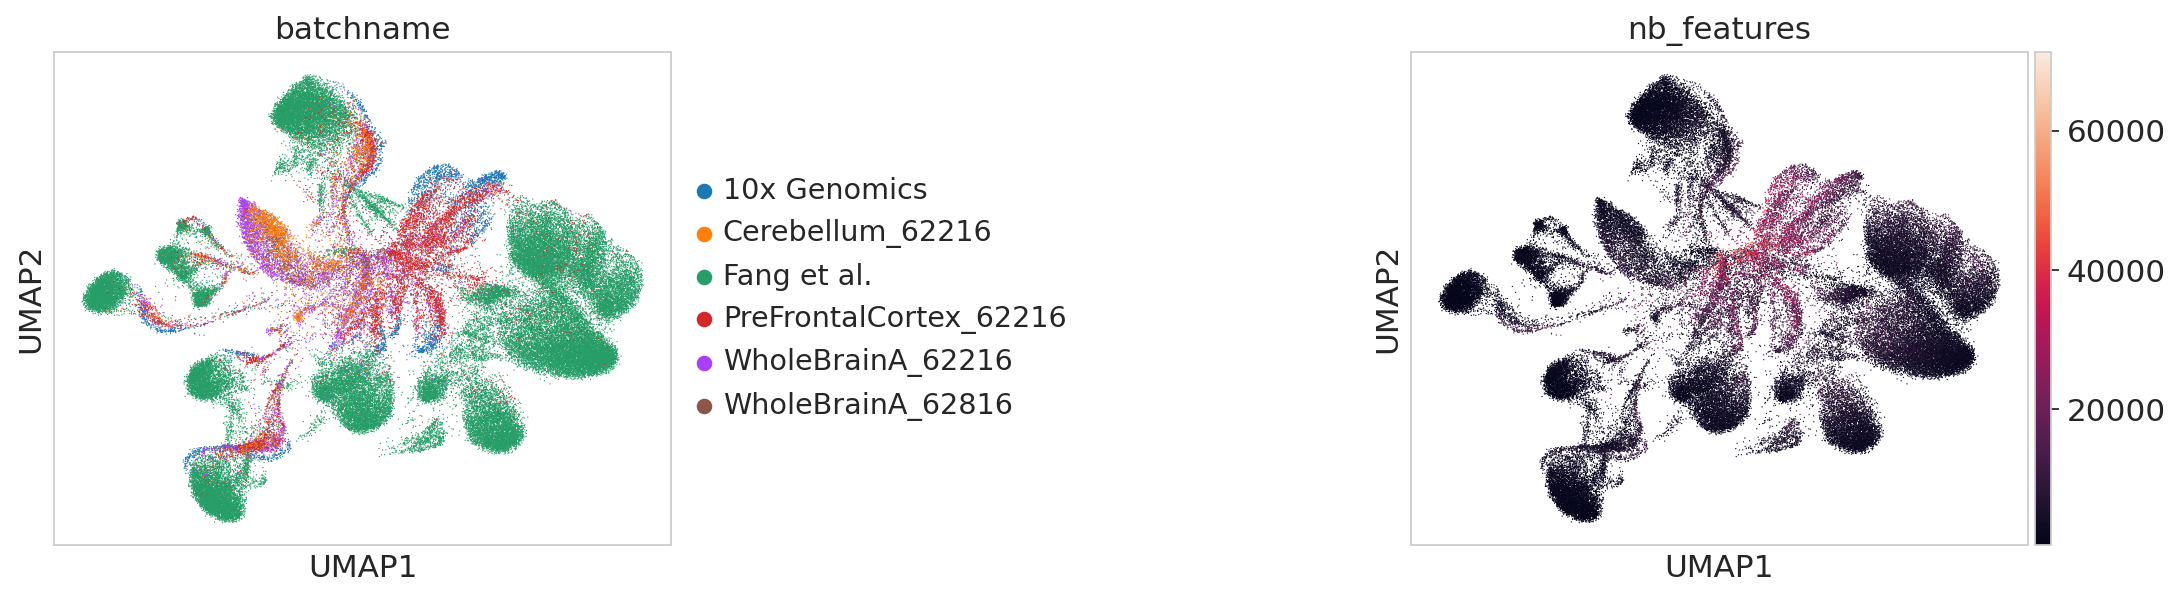

In [93]:
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=1)

### Saving the data

In [92]:
adatamerged.write('large_dataset_merged_dataset.h5ad')